In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize' ]= 16,9

from thompson_sampling.models import BatchBayesLinReg
from thompson_sampling.solvers import GaussianContextualSampler, GaussianUniversalContextualSampler,GaussianContextualSamplerSingleModel


Bad key "text.kerning_factor" on line 4 in
/home/thomas/anaconda3/envs/pytorch_GPU/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [ ]:
num_data = 1000

data_max = .5
data_min = -.5

np.random.seed(42)

x1 = np.linspace(data_min,data_max,num=num_data) 
x2 = np.random.choice([0,1,],p=[0.6,0.4],size=num_data)

y = x1.copy() 

x1[x2 == 0] =  np.random.uniform(-.5,data_max,num_data - sum(x2))

x3 = y + np.random.normal(0,data_max/4,num_data)

In [ ]:
#x1

In [ ]:
np.sum(x2 == 1)

387

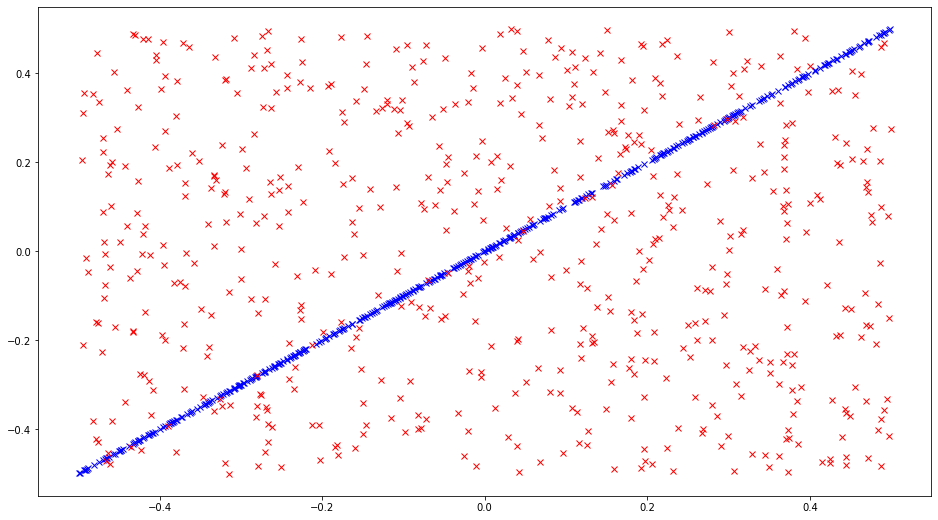

In [ ]:
plt.plot(x1[x2==1],y[x2==1],'x',color='blue')
plt.plot(x1[x2==0],y[x2==0],'x',color='red')

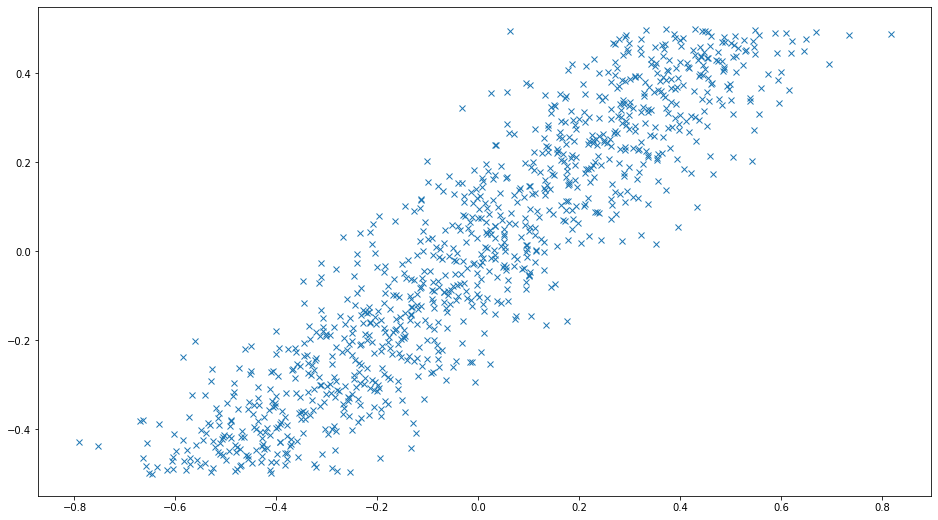

In [ ]:
plt.plot(x3,y,'x')

In [ ]:
yhat = x1*x2 + x3*(1-x2)

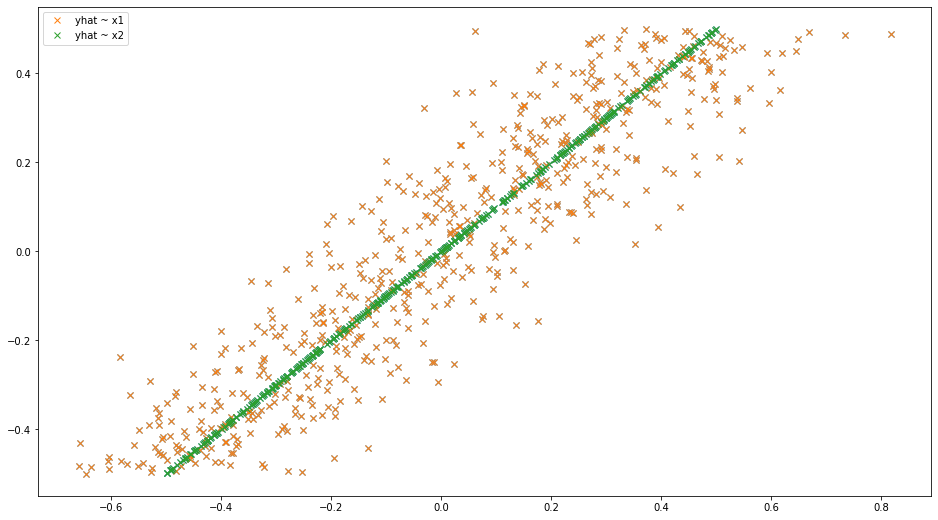

In [ ]:
plt.plot(yhat,y,'x')
plt.plot(x3[x2==0],y[x2==0],'x',label='yhat ~ x1')
plt.plot(x1[x2==1],y[x2==1], 'x',label='yhat ~ x2')
plt.legend()

In [ ]:
model1 = BatchBayesLinReg(n_features = 3,alpha=1,beta=1)


In [ ]:
model1 = BatchBayesLinReg(n_features = 3,alpha=10,beta=10)
model1.cov_inv

# http://krasserm.github.io/2019/02/23/bayesian-linear-regression/

array([[0.1, 0. , 0. ],
       [0. , 0.1, 0. ],
       [0. , 0. , 0.1]])

In [ ]:
X = np.array([x1,x2,x3])
X.shape, y.shape

((3, 1000), (1000,))

In [ ]:

for x_batch, y_batch in zip(X.T,np.atleast_2d(y).T):
    
    model1.observe(x_batch,y_batch)
    

In [ ]:
x_batch

array([0.03295779, 0.        , 0.37172255])

In [ ]:
y_batch

array([0.5])

In [ ]:
y_hat_dist = model1.predict(X.T)

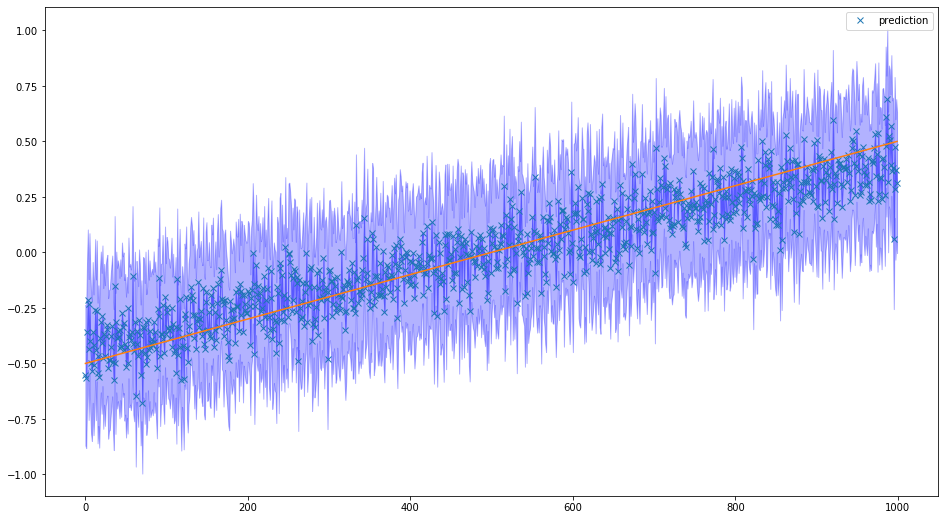

In [ ]:
y_hat = y_hat_dist.mean()
y_hat_std = y_hat_dist.std()


plt.fill_between(np.arange(num_data), y_hat, y_hat - y_hat_std, alpha = 0.3,color='blue')
plt.fill_between(np.arange(num_data), y_hat, y_hat + y_hat_std, alpha = 0.3,color='blue')


yhat_model = model1.weights_dist.mean @ X
plt.plot(yhat_model,'x',label='prediction')
plt.plot(y)
plt.legend()

In [ ]:
model1.weights_dist.mean

array([ 0.02321096, -0.00115712,  0.84355926])

In [ ]:
np.mean((y-yhat_model)**2)

0.013057478347663057

# w ts

In [ ]:
universal=False
beta = 1
alpha = 10

In [ ]:
model2 = BatchBayesLinReg(n_features = 3,alpha=1,beta=10)

In [ ]:

gcs1 = GaussianContextualSampler(BatchBayesLinReg,num_arms=2, num_context = 3+1,model_params={'alpha':alpha, 'beta':beta})
gcs2 = GaussianContextualSampler(BatchBayesLinReg,num_arms=2, num_context = 3+1,model_params={'alpha':alpha, 'beta':beta})
gcs3 = GaussianContextualSampler(BatchBayesLinReg,num_arms=2, num_context = 3+1,model_params={'alpha':alpha, 'beta':beta})


if universal:

    gcs1 = GaussianUniversalContextualSampler(BatchBayesLinReg,num_arms=2, num_context = 3+1,model_params={'alpha':alpha, 'beta':beta})
    gcs2 = GaussianUniversalContextualSampler(BatchBayesLinReg,num_arms=2, num_context = 3+1,model_params={'alpha':alpha, 'beta':beta})
    gcs3 = GaussianUniversalContextualSampler(BatchBayesLinReg,num_arms=2, num_context = 3+1,model_params={'alpha':alpha, 'beta':beta})

In [ ]:
def make_attention(X):
    attention1 = gcs1.choose_arm(X)
    attention2 = gcs2.choose_arm(X)
    attention3 = gcs3.choose_arm(X)
    
    
    
    attention = np.array([attention1, attention2, attention3])
    return attention

def make_input(X):
    attention = make_attention(X)
    
    input_vec = x_batch * attention
    return input_vec

In [ ]:
def predict_with_mix(X):
    input_vec = make_input(add_intercept(X))
    pred_dist = model2.predict(X)
    return pred_dist
    
    
def add_intercept(X):
    X = np.append(X,1)
    return X

In [ ]:
from sklearn.model_selection import train_test_split

num_epochs = 1

In [ ]:
# for j in range(num_epochs):
#     X_train, X_test, y_train, y_test = train_test_split(X.T, y, test_size=0.01, random_state=42)
#     for i,(x_batch, y_batch) in enumerate(zip(X.T,np.atleast_2d(y).T)):
#         #context = np.concatenate(x_batch)

#         x_batch_attention = add_intercept(x_batch)
#         attention = make_attention(x_batch_attention)

#         input_vec = x_batch * attention

#         if i % (num_data/20) == 0:
#             plt.figure()
#             #gcs1.choose_arm_and_plot(x_batch)
#             gcs2.choose_arm_and_plot(x_batch_attention)
#             #gcs3.choose_arm_and_plot(x_batch)


#         error = model2.observe(input_vec,y_batch)

#         gcs1.update(attention[0], x_batch_attention, error)
#         gcs2.update(attention[1], x_batch_attention, error)
#         gcs2.update(attention[2], x_batch_attention, error)
    

In [ ]:
x_batch

array([0.03295779, 0.        , 0.37172255])

In [ ]:
model2.weights_dist.mean

array([0., 0., 0.])

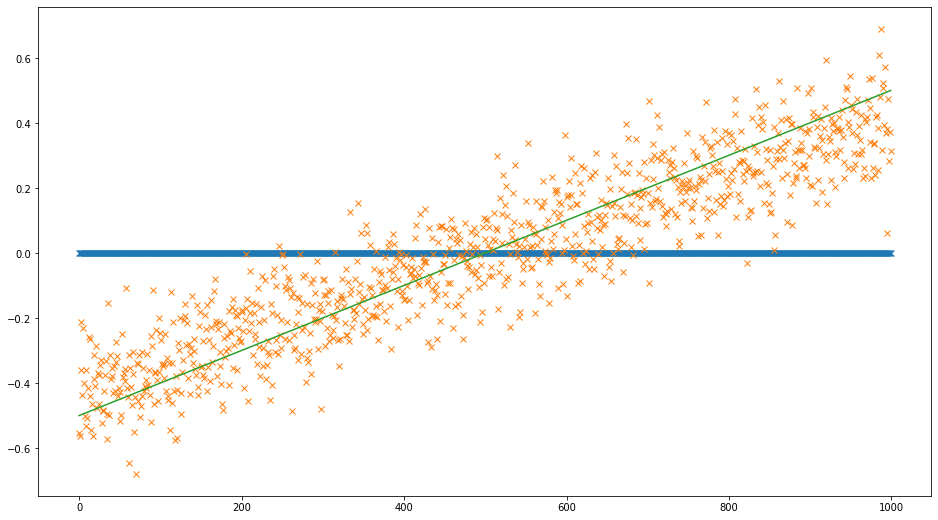

In [ ]:
y_hat = []
y_hat_std = []
for x in X.T:
    y_hat += [predict_with_mix(x).mean()]
    y_hat_std += [predict_with_mix(x).std()]
    
    
    
plt.plot(y_hat,'x')
plt.plot(yhat_model,'x')
plt.plot(y)


In [ ]:
a = [make_attention(add_intercept(X.T[0])) for x in range(100)]
np.mean(a,0)

array([0.62, 0.51, 0.55])

In [ ]:
a = [make_attention(add_intercept(X.T[1])) for x in range(100)]
np.mean(a,0)

array([0.48, 0.52, 0.47])

In [ ]:
add_intercept(X.T[0])

array([-0.31486707,  0.        , -0.64657541,  1.        ])

In [ ]:
add_intercept(X.T[1])

array([-0.498999  ,  1.        , -0.65318251,  1.        ])

In [ ]:
X.T[1]

array([-0.498999  ,  1.        , -0.65318251])

In [ ]:
do_add_intercept = False


In [ ]:
# TODO: Sample from different Arms you honk

In [ ]:


def make_attention(X):
    return gcssm.choose_arm(np.array(X))

def add_intercept(X):
    if do_add_intercept:
        X = np.append(X,np.atleast_1d(1))
    return X

In [ ]:
model3 = BatchBayesLinReg(n_features = 3+do_add_intercept,alpha=1,beta=10)
gcssm = GaussianContextualSamplerSingleModel(BatchBayesLinReg,num_arms=3, num_context = 3+do_add_intercept,model_params={'alpha':1, 'beta':4})

a = [make_attention(add_intercept(X.T[1]))['arm'] for x in range(1000)]
np.mean(a,0)

array([0.596, 0.625, 0.598])

In [ ]:
def predict_with_mix(X):
    #input_vec = make_input(add_intercept(X))
    pred_dist = model3.predict(X)
    return pred_dist

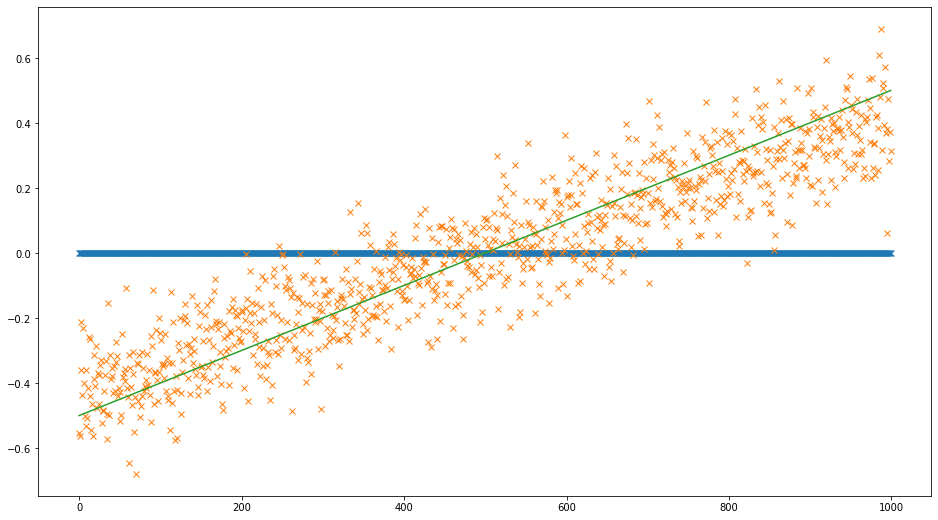

In [ ]:
y_hat = []
y_hat_std = []
for x in X.T:
    y_hat += [predict_with_mix(add_intercept(x)).mean()]
    y_hat_std += [predict_with_mix(add_intercept(x)).std()]
    
    
    
plt.plot(y_hat,'x')
plt.plot(yhat_model,'x')
plt.plot(y)


In [ ]:
meta_errors = []
for j in range(3):
    errors = []
    X_train, X_test, y_train, y_test = train_test_split(X.T, y, test_size=0.001, random_state=42,shuffle=True)
    for i,(x_batch, y_batch) in enumerate(zip(X_train ,np.atleast_2d(y_train).T)):
        #context = np.concatenate(x_batch)
        #print(x_batch.shape)
        #print(y_batch.shape)

        x_batch_attention = add_intercept(x_batch)
        attention = make_attention(x_batch_attention)

        input_vec = x_batch_attention * add_intercept(attention['arm'])

#         if i % (num_data/20) == 0:
#             plt.figure()
#             #gcs1.choose_arm_and_plot(x_batch)
#             gcs2.choose_arm_and_plot(x_batch_attention)
#             #gcs3.choose_arm_and_plot(x_batch)


        error = model3.observe(input_vec,y_batch)
        errors.append(error)

        gcssm.update(attention['arm_ix'], x_batch_attention, error)
    meta_errors.append(np.mean(error))

    

In [ ]:
X_train.shape, y_train.shape

((999, 3), (999,))

In [ ]:
meta_errors

[0.003050713932670866, 0.003218226081571155, 0.147795952359432]

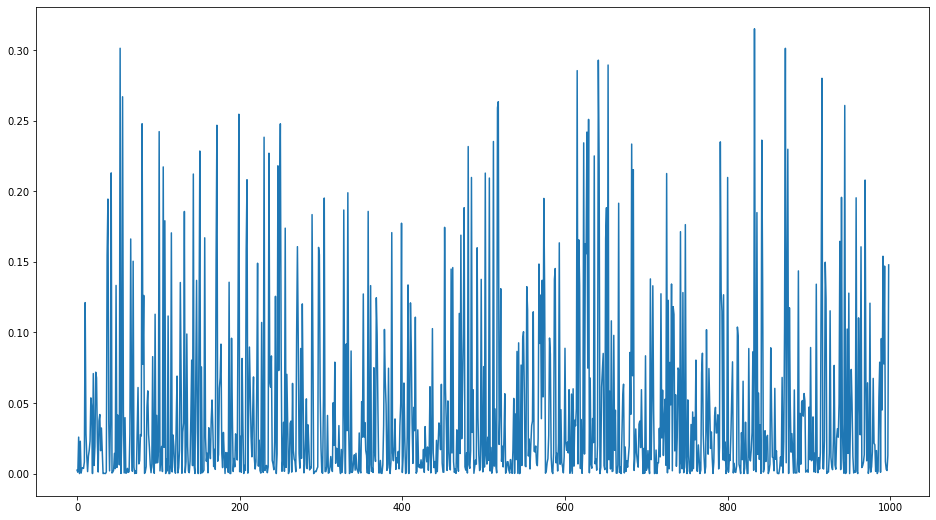

In [ ]:
plt.plot(errors)

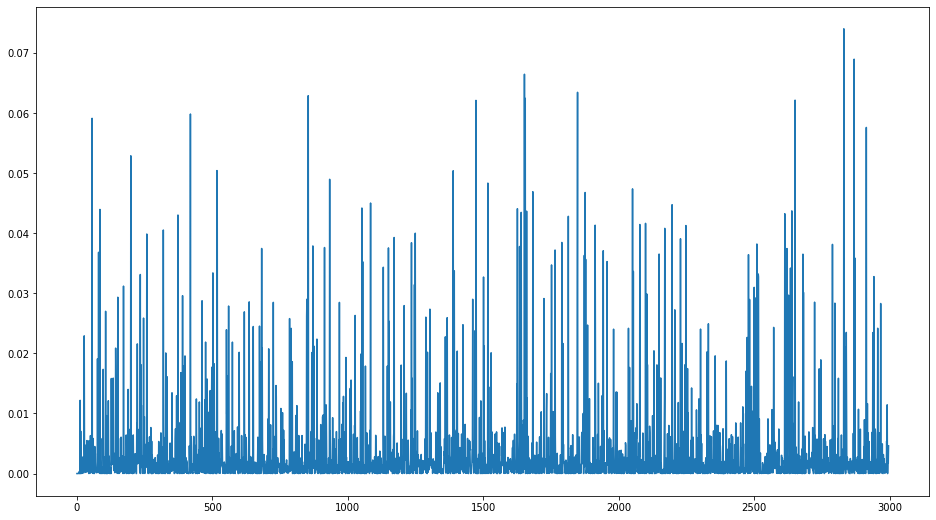

In [ ]:
plt.plot(gcssm.errors)

In [ ]:
x_batch * attention['arm'], attention['arm'] 

(array([-0.078643,  0.      , -0.      ]), array([1., 1., 0.]))

In [ ]:
x_batch

array([-0.078643  ,  0.        , -0.40163421])

In [ ]:
attention['arm_ix']

2

In [ ]:
a = [make_attention(add_intercept(X.T[1]))['arm'] for x in range(1000)]
np.mean(a,0)

array([0.585, 0.614, 0.54 ])

In [ ]:
def predict_with_mix(X):
    #input_vec = make_input(add_intercept(X))
    pred_dist = model3.predict(X)
    return pred_dist

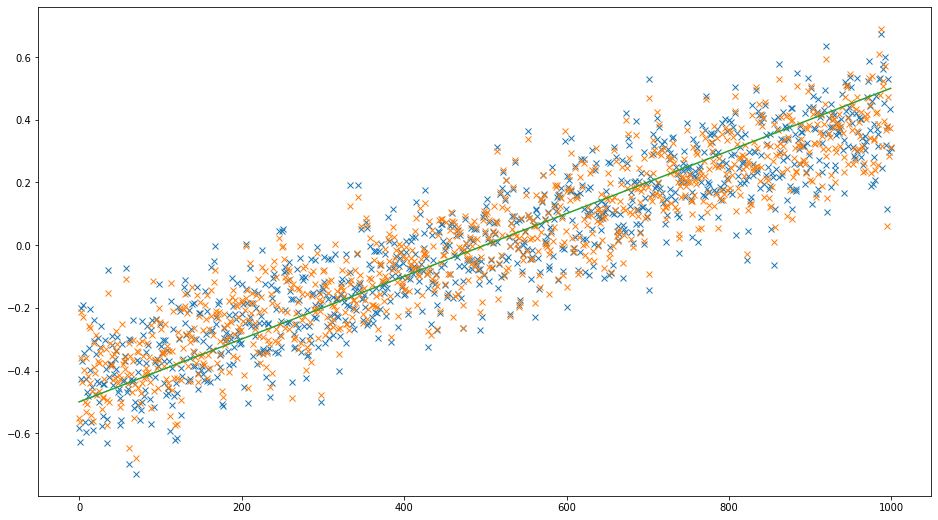

In [ ]:
y_hat = []
y_hat_std = []
for x in X.T:
    y_hat += [predict_with_mix(add_intercept(x)).mean()]
    y_hat_std += [predict_with_mix(add_intercept(x)).std()]
    
    
    
plt.plot(y_hat,'x')
plt.plot(yhat_model,'x')
plt.plot(y)


In [ ]:
gcssm.model.weights_dist.mean, gcssm.model.weights_dist.cov

(array([ 0.04116749,  0.03911132, -0.0309472 ,  0.00376022,  0.00228091,
         0.00021815]),
 array([[ 2.25964790e-04, -6.89661444e-05, -6.20087767e-05,
         -1.71063819e-05, -6.26100751e-05,  6.11447717e-06],
        [-6.89661444e-05,  2.31722466e-04, -6.52884629e-05,
          9.16085805e-06, -6.03042311e-05, -1.23306179e-05],
        [-6.20087767e-05, -6.52884629e-05,  2.47757352e-04,
         -1.60304793e-05, -6.13142931e-05,  6.97841956e-06],
        [-1.71063819e-05,  9.16085805e-06, -1.60304793e-05,
          1.12665213e-03,  2.78768553e-05, -3.49972688e-04],
        [-6.26100751e-05, -6.03042311e-05, -6.13142931e-05,
          2.78768553e-05,  3.24757311e-04,  1.27970978e-05],
        [ 6.11447717e-06, -1.23306179e-05,  6.97841956e-06,
         -3.49972688e-04,  1.27970978e-05,  9.66982269e-04]]))

In [ ]:
gcssm.arms

OrderedDict([(0, array([0., 1., 1.])),
             (1, array([1., 0., 1.])),
             (2, array([1., 1., 0.])),
             (3, array([1., 0., 0.])),
             (4, array([0., 1., 0.])),
             (5, array([0., 0., 1.])),
             (6, array([1., 1., 1.]))])

In [ ]:
X.shape

(3, 1000)

In [ ]:
from thompson_sampling.models import NeuralNetwork, DenseLayer, DropoutLayer, AttentionDropoutLayer

In [ ]:
X_train = X_train.T
y = np.atleast_2d(y)

X.shape, y.shape

((3, 1000), (1, 1000))

In [ ]:
y.shape

(1, 1000)

In [ ]:
model = NeuralNetwork(loss='mean-square-error')
model.addLayer(inputDimension=X.shape[0], units=1, activation='')#,layer_type=AttentionDropoutLayer)


num_iterations = 10000
for ix in range(num_iterations):
    # minibatch
    #X_train, X_test, Y_train, y_test = train_test_split(X.T, Y.T, test_size=0.7, random_state=42)
    #X_train = X_train.T
    #Y_train = Y_train.T
    #X_train, Y_train = shuffle(X,Y)

    A = model.forward(X)
    model.backward(A, y)
    model.update()
    if ix % (num_iterations/10) == 0:
        print('cost:', model.cost(y, A))

cost: 0.0834747946882493
cost: 0.014918467827474134
cost: 0.013166289153864402
cost: 0.013039645375226443
cost: 0.013028206181378905
cost: 0.013027149674947579
cost: 0.01302705190812739
cost: 0.013027042859486812
cost: 0.013027042021993368
cost: 0.013027041944479387


ensemble prediction cost: 0.0130270419373051
yhat_cost 0.009767486147838596


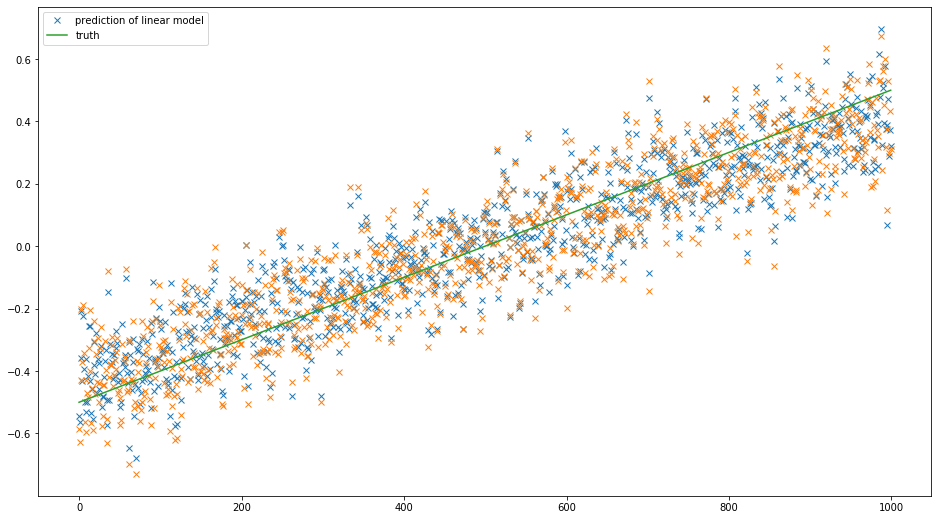

In [ ]:
num_predictive_samples = 10

predictive_sample_list = []

for i in range(num_predictive_samples):
    predictive_sample_list += [model.forward(X).squeeze()]


pred_mean = np.mean(predictive_sample_list,0)
pred_std = np.std(predictive_sample_list,0)

mean_prediction_cost = model.cost(y,pred_mean)

print(f'ensemble prediction cost: {mean_prediction_cost}')
print(f'yhat_cost {model.cost(y,yhat)}')


#plt.plot(np.array(range(1000)),pred_mean,label='prediction of linear model')
plt.plot(pred_mean,'x',label='prediction of linear model')
plt.plot(y_hat,'x')

#plt.plot(np.array(range(1000)),y.squeeze(),label='truth',alpha=0.1)

#plt.fill_between(np.array(range(1000)), pred_mean, pred_mean - pred_std, alpha = 0.3,color='blue')
#plt.fill_between(np.array(range(1000)), pred_mean, pred_mean + pred_std, alpha = 0.3,color='blue')

# for sample in predictive_sample_list:
#    plt.plot(np.array(range(1000)), 'x', sample,alpha=0.3)
    
plt.plot(y.squeeze(),label='truth')

#plt.plot(X.squeeze(),y.squeeze(),label='truth')
plt.legend()

In [ ]:
model = NeuralNetwork(loss='mean-square-error')
model.addLayer(inputDimension=X.shape[0], units=10, activation='tanh',layer_type = DropoutLayer)

#model.addLayer( units=10, activation='tanh')#,layer_type = DropoutLayer)

model.addLayer( units=1, activation='',)
model


num_iterations = 10000
for ix in range(num_iterations):
    # minibatch
    #X_train, X_test, Y_train, y_test = train_test_split(X.T, Y.T, test_size=0.7, random_state=42)
    #X_train = X_train.T
    #Y_train = Y_train.T
    #X_train, Y_train = shuffle(X,Y)

    A = model.forward(X)
    model.backward(A, y)
    model.update()
    if ix % (num_iterations/10) == 0:
        print('cost:', model.cost(y, A))

cost: 0.08358431246914842
cost: 0.08220340872986096
cost: 0.05084014259867563
cost: 0.01623541718708746
cost: 0.06861564073751675
cost: 0.03457986605335793
cost: 0.015071293349567203
cost: 0.01989754100284813
cost: 0.015517199631379453
cost: 0.019967739135877714


ensemble prediction cost: 0.0124540330739508
yhat_cost 0.009767486147838596


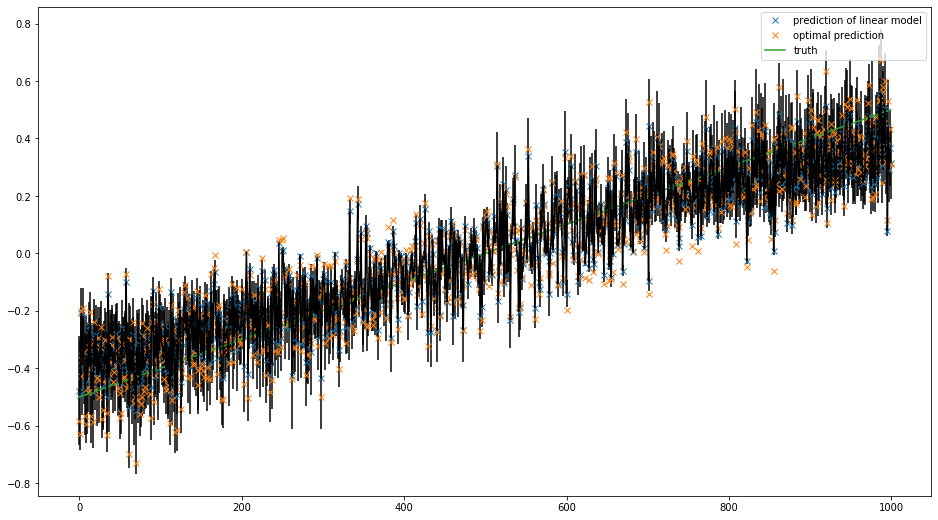

In [ ]:
num_predictive_samples = 10

predictive_sample_list = []

for i in range(num_predictive_samples):
    predictive_sample_list += [model.forward(X).squeeze()]


pred_mean = np.mean(predictive_sample_list,0)
pred_std = np.std(predictive_sample_list,0)

mean_prediction_cost = model.cost(y,pred_mean)

print(f'ensemble prediction cost: {mean_prediction_cost}')
print(f'yhat_cost {model.cost(y,yhat)}')


#plt.plot(np.array(range(1000)),pred_mean,label='prediction of linear model')
plt.plot(pred_mean,'x',label='prediction of linear model')

plt.plot(y_hat,'x',label='optimal prediction')

#plt.plot(np.array(range(1000)),y.squeeze(),label='truth',alpha=0.1)

# plt.fill_between(np.array(range(1000)), pred_mean, pred_mean - pred_std, alpha = 0.1,color='blue')
# plt.fill_between(np.array(range(1000)), pred_mean, pred_mean + pred_std, alpha = 0.1,color='blue')



plt.errorbar(np.array(range(1000)), pred_mean, pred_std, color='black' )

#for sample in predictive_sample_list:
#    plt.plot(np.array(range(1000)), sample,alpha=0.3)
    
plt.plot(y.squeeze(),label='truth')

#plt.plot(X.squeeze(),y.squeeze(),label='truth')
plt.legend()

In [ ]:
model = NeuralNetwork(loss='mean-square-error')

model.addLayer(inputDimension=X.shape[0], units=10, activation='tanh')#,layer_type = DropoutLayer)

#model.addLayer( units=10, activation='tanh',layer_type = DropoutLayer)


model.addLayer( units=1, activation='',)
model


num_iterations = 10000
for ix in range(num_iterations):
    # minibatch
    #X_train, X_test, Y_train, y_test = train_test_split(X.T, Y.T, test_size=0.7, random_state=42)
    #X_train = X_train.T
    #Y_train = Y_train.T
    #X_train, Y_train = shuffle(X,Y)

    A = model.forward(X)
    model.backward(A, y)
    model.update()
    if ix % (num_iterations/10) == 0:
        print('cost:', model.cost(y, A))

cost: 0.0833887054388969
cost: 0.07814510227782179
cost: 0.028504552071967365
cost: 0.013607960136964152
cost: 0.01295729589199433
cost: 0.012884403848689942
cost: 0.012875478150044731
cost: 0.012873559839113646
cost: 0.012872379594847548
cost: 0.012871266381978313


ensemble prediction cost: 0.012870148611912375
yhat_cost 0.009767486147838596


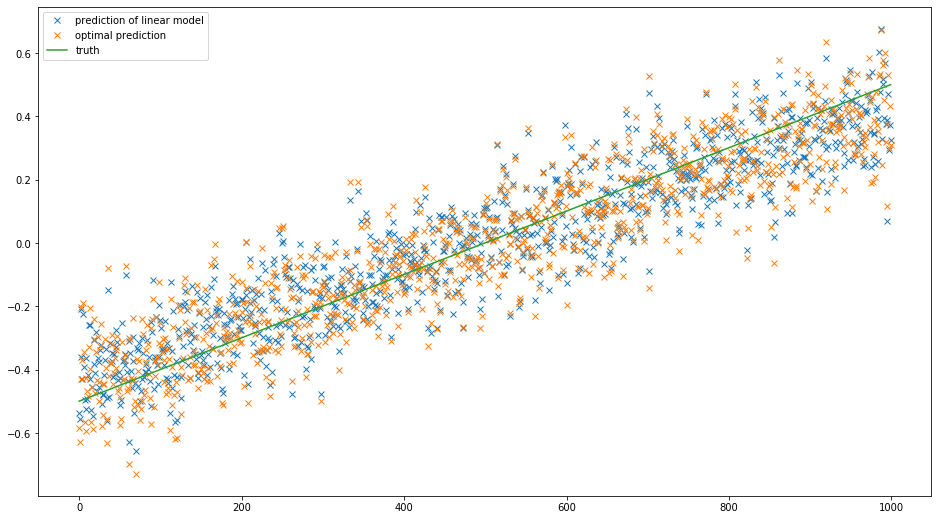

In [ ]:
num_predictive_samples = 10

predictive_sample_list = []

for i in range(num_predictive_samples):
    predictive_sample_list += [model.forward(X).squeeze()]


pred_mean = np.mean(predictive_sample_list,0)
pred_std = np.std(predictive_sample_list,0)

mean_prediction_cost = model.cost(y,pred_mean)

print(f'ensemble prediction cost: {mean_prediction_cost}')
print(f'yhat_cost {model.cost(y,yhat)}')


#plt.plot(np.array(range(1000)),pred_mean,label='prediction of linear model')
plt.plot(pred_mean,'x',label='prediction of linear model')

plt.plot(y_hat,'x',label='optimal prediction')

#plt.plot(np.array(range(1000)),y.squeeze(),label='truth',alpha=0.1)

# plt.fill_between(np.array(range(1000)), pred_mean, pred_mean - pred_std, alpha = 0.1,color='blue')
# plt.fill_between(np.array(range(1000)), pred_mean, pred_mean + pred_std, alpha = 0.1,color='blue')

#for sample in predictive_sample_list:
#    plt.plot(np.array(range(1000)), sample,alpha=0.3)
    
plt.plot(y.squeeze(),label='truth')

#plt.plot(X.squeeze(),y.squeeze(),label='truth')
plt.legend()

ToDo:
    Add attentional Dropout to the model and see what happend

In [ ]:
model = NeuralNetwork(loss='mean-square-error')

model.addLayer(inputDimension=1, units=10, activation='tanh')#,layer_type = DropoutLayer)

model.addLayer( units=10, activation='tanh',layer_type = AttentionDropoutLayer)


model.addLayer( units=1, activation='',)
model



X = np.atleast_2d(np.linspace(0,1,100))

In [ ]:
X.shape

(1, 100)

In [ ]:
model.forward(X,np.ones(10))

array([[ 0.00000000e+00, -1.53252073e-08, -3.06504135e-08,
        -4.59756175e-08, -6.13008181e-08, -7.66260143e-08,
        -9.19512048e-08, -1.07276389e-07, -1.22601565e-07,
        -1.37926732e-07, -1.53251889e-07, -1.68577035e-07,
        -1.83902168e-07, -1.99227288e-07, -2.14552394e-07,
        -2.29877484e-07, -2.45202557e-07, -2.60527612e-07,
        -2.75852648e-07, -2.91177665e-07, -3.06502659e-07,
        -3.21827632e-07, -3.37152581e-07, -3.52477505e-07,
        -3.67802404e-07, -3.83127276e-07, -3.98452120e-07,
        -4.13776935e-07, -4.29101720e-07, -4.44426473e-07,
        -4.59751194e-07, -4.75075881e-07, -4.90400534e-07,
        -5.05725151e-07, -5.21049731e-07, -5.36374273e-07,
        -5.51698776e-07, -5.67023239e-07, -5.82347660e-07,
        -5.97672039e-07, -6.12996374e-07, -6.28320665e-07,
        -6.43644909e-07, -6.58969107e-07, -6.74293257e-07,
        -6.89617357e-07, -7.04941407e-07, -7.20265406e-07,
        -7.35589352e-07, -7.50913244e-07, -7.66237082e-0

In [ ]:
np.random.seed(4)

In [ ]:
model = NeuralNetwork(loss='mean-square-error',randomMultiplier=1)

model.addLayer(inputDimension=1, units=10, activation='tanh')#,layer_type = DropoutLayer)

model.addLayer( units=9, activation='tanh')




model.addLayer( units=1, activation='tanh',layer_type = AttentionDropoutLayer)

model.addLayer( units=9, activation='tanh')




model.addLayer( units=1, activation='',layer_type = AttentionDropoutLayer)
model





[
  1 -> Dense layer (nx=1, nh=10, activation=tanh)
  2 -> Dense layer (nx=10, nh=9, activation=tanh)
  3 -> Attention Dropout layer (nx=9, nh=1, activation=tanh)
  4 -> Dense layer (nx=1, nh=9, activation=tanh)
  5 -> Attention Dropout layer (nx=9, nh=1, activation=none)
]

In [ ]:
X = np.atleast_2d(np.linspace(-1,1,100))
attention = np.ones(model.layers[2].weights.shape)

dropout_percent = 0.5

attention = np.random.binomial([np.ones((model.layers[2].weights.shape))],1-dropout_percent)[0]#.shape
attention

array([[0, 0, 0, 1, 0, 0, 1, 1, 1]])

In [ ]:
yhat = []

for x in X.T:
    yhat += [model.forward(np.atleast_2d(x), attention)]

yhat = np.array(yhat)

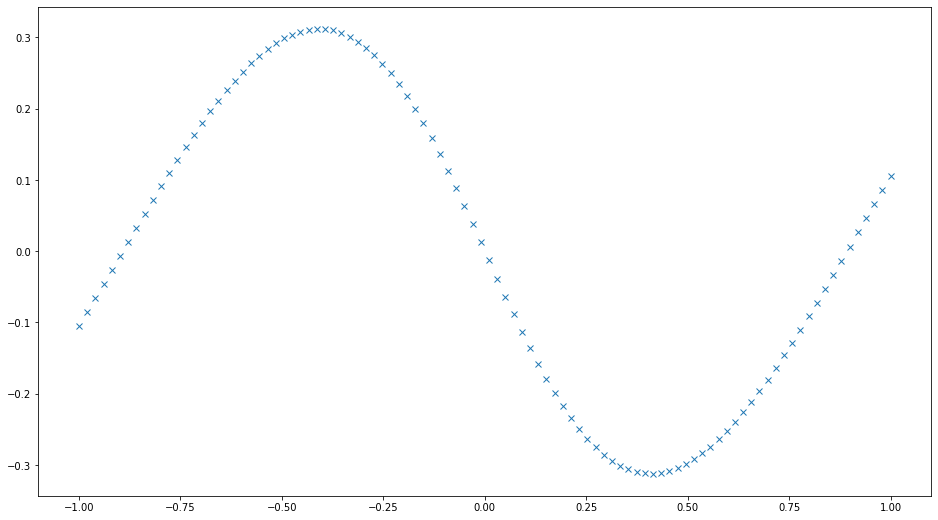

In [ ]:
plt.plot(X.squeeze(), yhat.squeeze(),'x')

In [ ]:
full_attention = np.ones(model.layers[2].weights.shape)


In [ ]:
yhat_full = []

for x in X.T:
    yhat_full += [model.forward(np.atleast_2d(x), full_attention)]

yhat_full = np.array(yhat_full)

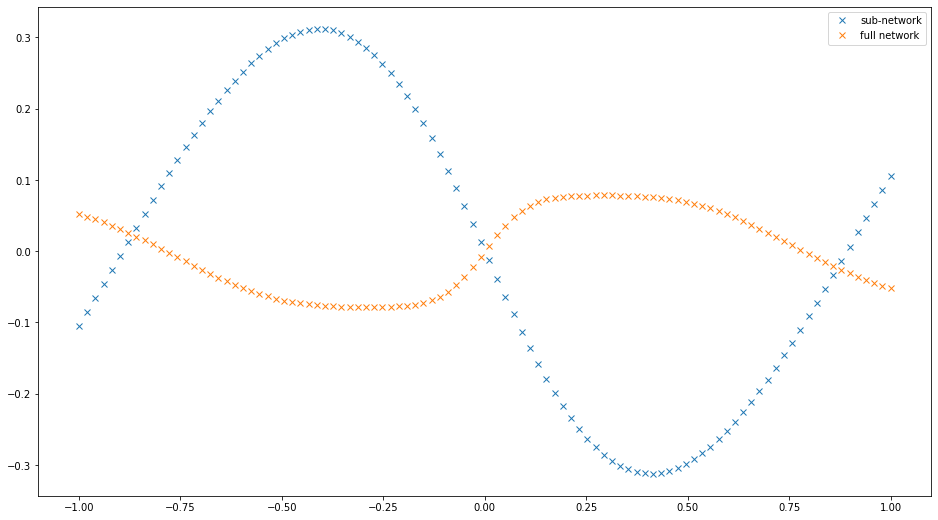

In [ ]:
plt.plot(X.squeeze(), yhat.squeeze(),'x',label='sub-network')
plt.plot(X.squeeze(), yhat_full.squeeze(),'x',label='full network')
plt.legend()

# ToDo:
1. noncontextually recover the optimal attention:
    - initiate noncontextual Bandits for each node
    - train them independently?
2. build contextual dropout scheme and recover it
    - linearly decide on whether to use an arm or not
    - recover with linear cts
   

In [ ]:
#export

import scipy.stats as stats
class GaussianBandit():

    def __init__(self, num_options = 2, mean_prior = 0, std_prior = 1):
        """initialize BetaBandit"""
        self.num_options = num_options

        #setting the prior, either uninformative or user generated
#         if prior == None:
#             self.prior = np.ones(shape=(num_options,2))
#         else:
#             assert prior.shape == (num_options,2), f"the prior seems to have wrong dimensionality, please conform to (num_options, 2){(num_options,2)}"
#             self.prior = prior

        self.trials = np.zeros(shape=(num_options,))
        self.sum_x = np.zeros(shape=(num_options,))
        self.sum_x2 = np.zeros(shape=(num_options,))

        self.mean_prior = mean_prior
        self.std_prior = std_prior

    def choose_arm(self):
        """draw from arms.
        arm with the highest expected outcome wins. 
        expected outcome is determined stochastically, so even an arm with bad 
        outcome until now will have a chance of being drawn"""

        sampled_outcomes = []
        for i in range(self.num_options):
            
            if self.trials[i] > 1:
                mean = self.compute_online_mean(i)
                stdev = self.compute_online_std(i, mean)
            else:
                mean = 0
                stdev = 1
            

            dist = stats.norm(mean,stdev)
            
            sampled_outcome = dist.rvs()
            #print(sampled_outcome)
            
            sampled_outcomes += [sampled_outcome]
      
        return(np.argmax(np.array(sampled_outcomes))) 
        
    def update(self, arm, outcome):
        """update parameters of specific arm"""
        #count times arm has been drawn"""
        self.trials[arm] = self.trials[arm] +1
        #count number of successes on that arm"""

        # for decay factors: self.successes = self.successes *.99
        
        self.sum_x[arm] += outcome
        self.sum_x2[arm] += outcome*outcome
        
        
    def compute_online_mean(self, arm):
        return self.sum_x[arm] / (self.trials[arm])
    
    def compute_online_std(self, arm, mean = None):
        mean = mean or self.compute_online_mean(arm)
        #np max against degeneration)
        return np.max([np.sqrt((self.sum_x2[arm] / (self.trials[arm])) - (mean * mean)), 0.00001])
        
        

        
    def plot_params(self):
        """plot the distributions that underly the arms"""
        
        w = 10
        z = 5
        colors = iter(cm.rainbow(np.linspace(0, 1, self.num_options)))
            
        for k,i in enumerate(range(self.num_options)):
                color = next(colors)
                
                
            
            
                if self.trials[i] > 1:
                    mean = self.compute_online_mean(i)
                    stdev = self.compute_online_std(i, mean)
                else:
                    mean = 0
                    stdev = 1


                dist = stats.norm(mean,stdev)

                x = np.linspace(-6,6,100)
                y = dist.pdf(x)
                plt.plot(x,y,color=color,label="arm #%i"%(i+1))
                plt.fill_between(x,0,y,alpha=1/self.num_options,color=color)
                leg = plt.legend()
                plt.tight_layout
     

            

In [ ]:
gb = GaussianBandit(9)
[gb.choose_arm() for i in range(10)]


[0, 6, 8, 7, 1, 6, 8, 0, 4, 6]

# NEW

In [ ]:
from thompson_sampling.solvers import GaussianBandit

In [ ]:
class IndependentAttentionTS():
    def __init__(self,attention_size):
        self.ts_list = [GaussianBandit(num_options=2) for arm in range(attention_size)]
        
    def get_attention(self):
        
        attention = [ts.choose_arm() for ts in self.ts_list]
        return np.atleast_2d(attention)
    
    def update(self, attention, reward):
        for i, arm in enumerate(attention):
            ts = self.ts_list[i]
            
            ts.update(arm, reward)
            
            
class DependentAttentionTS():
    def __init__(self, attention_size, num_arms):
        self.arms = list(set([tuple(np.random.choice([0,1],p=[0.5,0.5],size = attention_size)) for i in range(num_arms)]))
        self.arms = np.array([np.array(arm) for arm in self.arms])
        self.ts = GaussianBandit(num_arms-1)
        
        
    def get_arm(self):
        return self.ts.choose_arm()
        
        
    def get_attention(self, arm):
        return self.arms[arm]
    
    def update(self, arm, reward):
        self.ts.update(arm,reward)
        
        
        
        
        
        

In [ ]:
dts = DependentAttentionTS(9, 30)
dts.arms, len(dts.arms), dts.ts.num_options

(array([[1, 0, 0, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 0, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 0, 0, 1],
        [1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 1, 0, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 0],
        [0, 0, 1, 1, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 1, 1, 0, 1, 1, 0],
        [1, 0, 1, 0, 0, 0, 1, 1, 0],
        [0, 0, 1, 1, 0, 0, 1, 0, 0],
        [1, 1, 0, 0, 0, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 1, 1, 1, 0],
        [0, 1, 1, 0, 0, 1, 1, 1, 0],
        [0, 1, 1, 0, 0, 1, 0, 1, 0],
        [0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1],
        [1, 0, 0, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 1, 0, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 0, 1, 1, 0],
 

In [ ]:
[dts.get_arm() for i in range(10)]

[21, 20, 3, 21, 24, 21, 8, 17, 25, 20]

In [ ]:
attention in dts.arms

True

In [ ]:
attention

array([[0, 0, 0, 1, 0, 0, 1, 1, 1]])

In [ ]:
iats = IndependentAttentionTS(attention_size=full_attention.shape[1])

In [ ]:
a = iats.get_attention()
a

array([[0, 0, 0, 0, 1, 1, 0, 1, 0]])

In [ ]:
arm= dts.get_arm()

dts.get_attention(arm)

array([0, 0, 1, 0, 0, 0, 1, 1, 1])

In [ ]:
iats.ts_list[1],iats.ts_list[1].trials

(<thompson_sampling.solvers.GaussianBandit at 0x7f27f52b21d0>, array([0., 0.]))

In [ ]:
#iats.update(a, 10)
epochs = 25

In [ ]:
for i in range(epochs):
    for x, y in zip(X.T, yhat):


        x = np.atleast_2d(add_intercept(x))
        arm = dts.get_arm()
        attention_new = dts.get_attention(arm)


        prediction = model.forward(x, attention_new)


        error = -(y - prediction)**2

        dts.update(arm, error[0][0])


    

ValueError: Domain error in arguments.

In [ ]:
dts.ts.num_options

In [ ]:
attention_new[0]

In [ ]:
error[0][0]

In [ ]:
a = [dts.get_attention(dts.get_arm()) for i in range(100)]
np.mean(a,0) > 0.5, np.mean(a,0)

In [ ]:
attention

In [ ]:
dts.ts.trials[3]

In [ ]:
pred_samples = 10

In [ ]:
ensemble_preds = []
for i in range(pred_samples):
    
    predictions_iats = []

    for x, y in zip(X.T, yhat):
    

        x = np.atleast_2d(add_intercept(x))
        arm = dts.get_arm()
        attention_new = dts.get_attention(arm)


        predictions_iats += [model.forward(x, attention_new).squeeze()]


        #error = (y - prediction)**2

        #iats.update(attention.squeeze(), error.squeeze())
        #gcssm.update(arms['arm_ix'], x.squeeze(), error.squeeze())
        
    ensemble_preds.append(np.array(predictions_iats))


In [ ]:
np.mean(ensemble_preds,0)

In [ ]:
plt.plot(np.mean(ensemble_preds,0),'x')
plt.plot(yhat.squeeze())

In [ ]:
dts.ts.plot_params()

In [ ]:
a = [dts.get_attention(dts.get_arm()) for i in range(100)]
np.mean(a,0) > 0.5, np.mean(a,0)

In [ ]:
attention

In [ ]:
#model3 = BatchBayesLinReg(n_features = 3+do_add_intercept,alpha=1,beta=10)

num_context = 1+do_add_intercept

gcssm = GaussianContextualSamplerSingleModel(BatchBayesLinReg,num_arms=attention.shape[1], num_context = num_context,model_params={'alpha':1, 'beta':4})

a = [make_attention(add_intercept(X.T[1]))['arm'] for x in range(100)]
np.mean(a,0)

In [ ]:
attention.shape

In [ ]:
num_context, attention.shape

In [ ]:
a[0].shape, attention.shape

In [ ]:
make_attention(add_intercept(X.T[1]))#['arm']

In [ ]:
gcssm.update(1,1,1)

In [ ]:
for x, y in zip(X.T, yhat):
    x = np.atleast_2d(add_intercept(x))
    arms = make_attention(x)
    
    attention_new = np.atleast_2d(arms['arm'])
    
    prediction = model.forward(x, attention_new)
    
    
    error = (y - prediction)**2
    
    
    gcssm.update(arms['arm_ix'], x.squeeze(), error.squeeze())
    
    
    
    
    

In [ ]:
a = [make_attention(add_intercept(X.T[1]))['arm'] for x in range(100)]
np.mean(a,0)

In [ ]:
attention

In [ ]:
yhat_ts = []

for x in X.T:
    a = make_attention(add_intercept(x))['arm']
    yhat_ts += [model.forward(np.atleast_2d(x), a)]

yhat_ts = np.array(yhat_ts)

In [ ]:
plt.plot(X.squeeze(), yhat_ts.squeeze(),label='ts-subnetwork')
plt.plot(X.squeeze(), yhat.squeeze(),'x',label='sub-network')
plt.plot(X.squeeze(), yhat_full.squeeze(),'x',label='full network')
plt.legend()